In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.12.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data1 = pd.read_csv('/content/drive/MyDrive/enron_complete1.csv')
data2 = pd.read_csv('/content/drive/MyDrive/enron_complete2.csv')
data3 = pd.read_csv('/content/drive/MyDrive/enron_complete3.csv')
data = pd.concat([data1,data2,data3])
data

,text,label
0,"Subject: what up , , your cam babe\nwhat are y...",spam
1,Subject: want to make more money ?\norder conf...,spam
2,Subject: food for thoughts\n[\njoin now - take...,spam
3,Subject: miningnews . net newsletter - tuesday...,spam
4,Subject: your pharmacy ta\nwould you want chea...,spam
...,...,...
5507,Subject: 8 : 30 am trade counts\noff to a weak...,ham
5508,Subject: re : new organisation for maximising ...,ham
5509,Subject: fw : info : please read - - feb 1 chu...,ham
5510,Subject: sf gate : text of gov . gray davis ' ...,ham


Text(0.5, 1.0, 'Spam/ham Data Distribution')

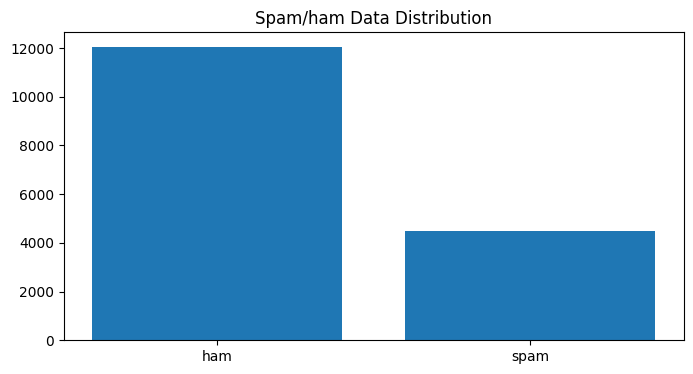

In [ ]:
val_count = data.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Spam/ham Data Distribution")

In [ ]:
data['spam'] = data['label'].apply(lambda x : 1 if x=="spam" else 0)

In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]:\S+|subject:\S+|nbsp"

In [ ]:
data.head()

,text,label,spam
0,"Subject: what up , , your cam babe\nwhat are y...",spam,1
1,Subject: want to make more money ?\norder conf...,spam,1
2,Subject: food for thoughts\n[\njoin now - take...,spam,1
3,Subject: miningnews . net newsletter - tuesday...,spam,1
4,Subject: your pharmacy ta\nwould you want chea...,spam,1


In [ ]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
data.text = data.text.apply(preprocess)


In [ ]:
data.head()

,text,label,spam
0,"subject: , , cam babe looking ? looking compan...",spam,1
1,subject: want make money ? order confirmation ...,spam,1
2,subject: food thoughts [ join - take free tour...,spam,1
3,subject: miningnews . net newsletter - tuesday...,spam,1
4,subject: pharmacy ta would want cheap perscrip...,spam,1


In [ ]:
!pip install wordcloud


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Text(0.5, 1.0, 'Spam Word Cloud')

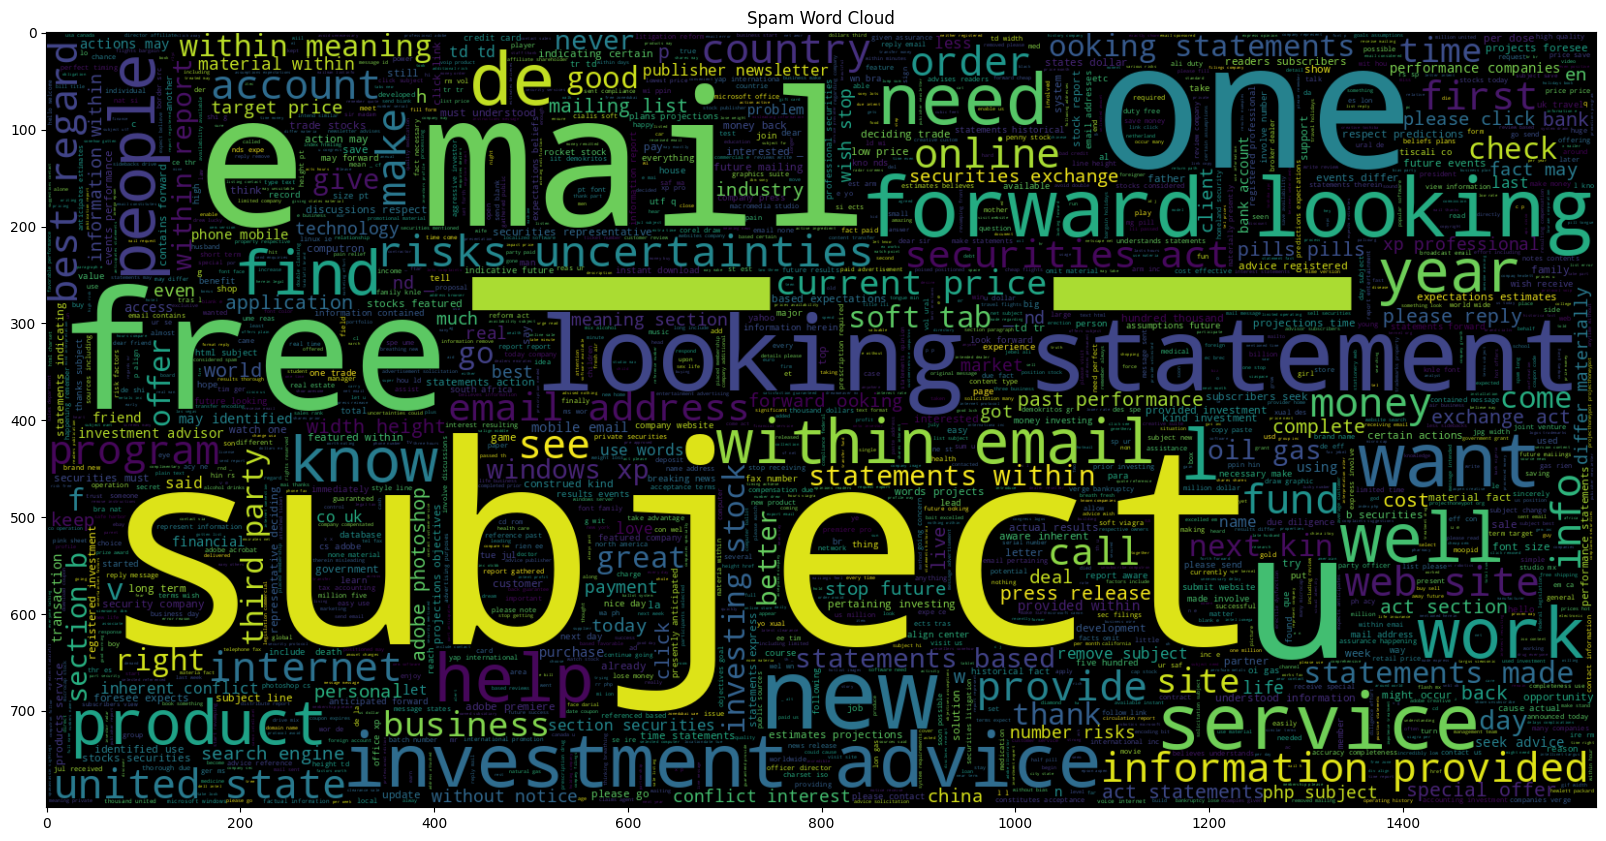

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.spam == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Spam Word Cloud")

Text(0.5, 1.0, 'Ham Word Cloud')

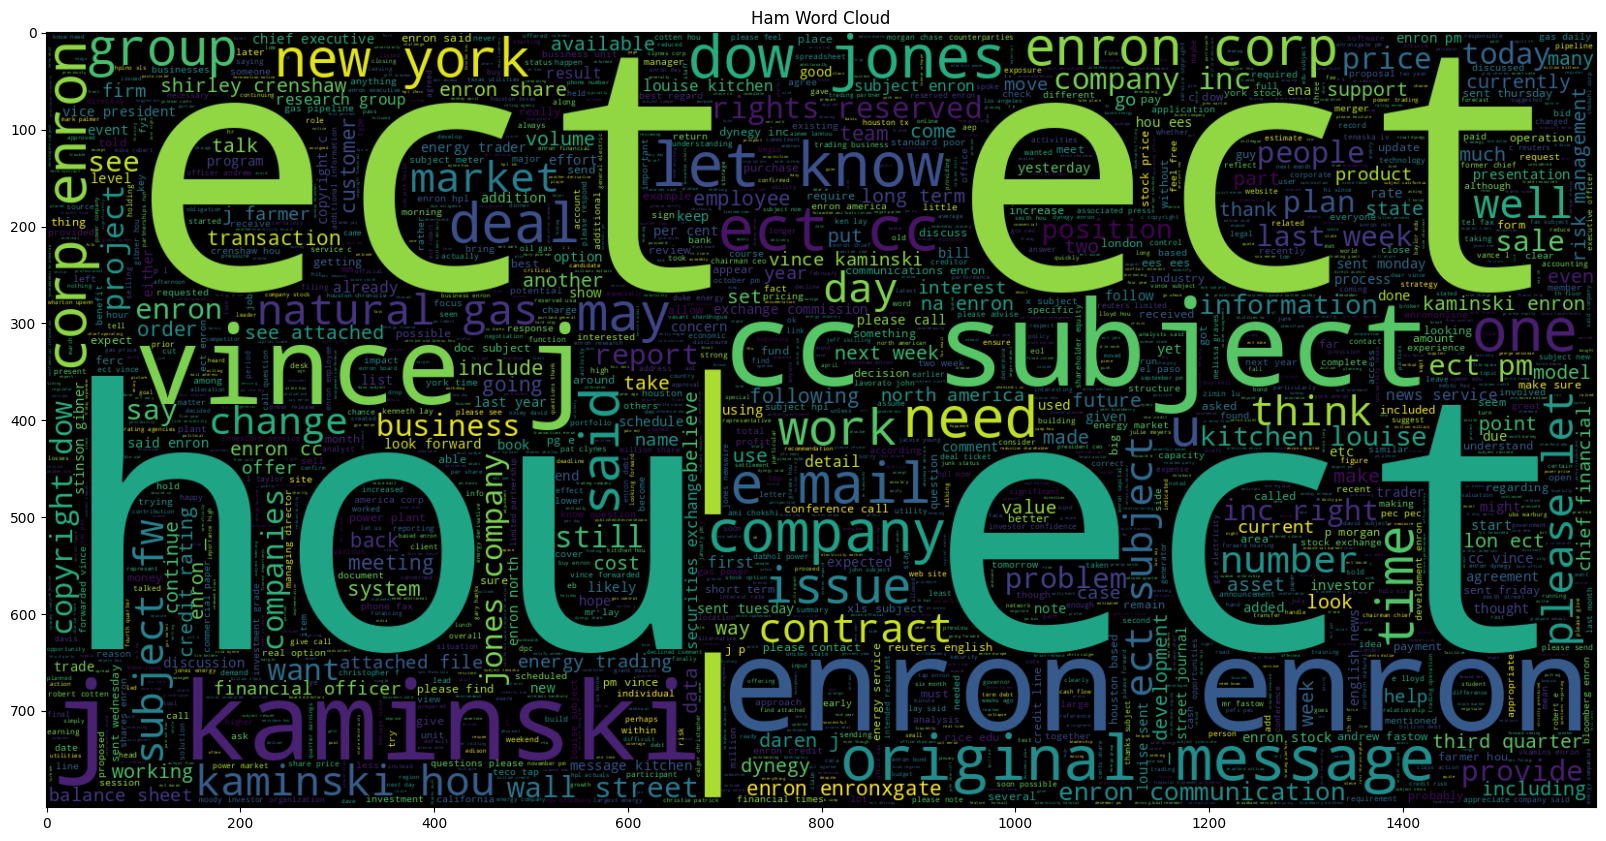

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.spam == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Ham Word Cloud")

In [ ]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 250

In [ ]:
x = data['text']
y = data['spam']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-TRAIN_SIZE, stratify=y,
                                         random_state=2) # Splits Dataset into Training and Testing set
print("Train Data size:", len(x_train))
print("Test Data size", len(x_test))

Train Data size: 13232
Test Data size 3309


In [ ]:
x_train.head(10)


425     subject: ixnepeinsve x @ x hello , visit amazi...
4235    subject: foreign language lessons fyi ! - - - ...
4008    subject: enron actuals june 02 thru 04 , 2000 ...
2249    subject: : know ' look . - - - - - original me...
1559    subject: revised nominations daren , received ...
2618    subject: deal 709296 astra daren , picky , dea...
1145    subject: info missing medical details found 20...
1166    subject: [ ilug ] assistance : col . michael b...
595     subject: impotency embarressing issue - buy on...
128     subject: - link dwl - g 510 802 . 11 g wireles...
Name: text, dtype: object

In [ ]:
data['len'] = data['text'].apply(lambda x : len(x.split()))

In [ ]:
data['len'].describe()

count    16541.000000
mean       261.224775
std        809.105058
min          1.000000
25%         53.000000
50%        120.000000
75%        262.000000
max      31672.000000
Name: len, dtype: float64

In [ ]:
data.groupby('spam').describe()

len                                                           
        count        mean         std  min   25%    50%     75%      max
spam                                                                    
0     12045.0  288.316895  931.402414  2.0  54.0  132.0  282.00  31672.0
1      4496.0  188.643683  277.885584  1.0  51.0  101.0  194.25   3861.0

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1000
print("Vocabulary Size :", vocab_size)


Vocabulary Size : 88638


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


x_train = pad_sequences(tokenizer.texts_to_sequences(x_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (13232, 250)
Testing X Shape: (3309, 250)


In [ ]:
y_test.shape


(3309,)

In [ ]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm = 0.2
embeding_dim = 70

In [ ]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=MAX_SEQUENCE_LENGTH))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])


In [ ]:
# Training
num_epochs = 3
early_stop = EarlyStopping(monitor='val_loss', patience=4)
history = model2.fit(x_train, y_train, epochs=num_epochs, 
                    validation_data=(x_test, y_test),callbacks =[early_stop], verbose=2)

Epoch 1/3
414/414 - 91s - loss: 0.1957 - accuracy: 0.9269 - val_loss: 0.0868 - val_accuracy: 0.9807 - 91s/epoch - 221ms/step
Epoch 2/3
414/414 - 56s - loss: 0.0341 - accuracy: 0.9937 - val_loss: 0.0571 - val_accuracy: 0.9883 - 56s/epoch - 134ms/step
Epoch 3/3
414/414 - 39s - loss: 0.0118 - accuracy: 0.9984 - val_loss: 0.0591 - val_accuracy: 0.9886 - 39s/epoch - 94ms/step


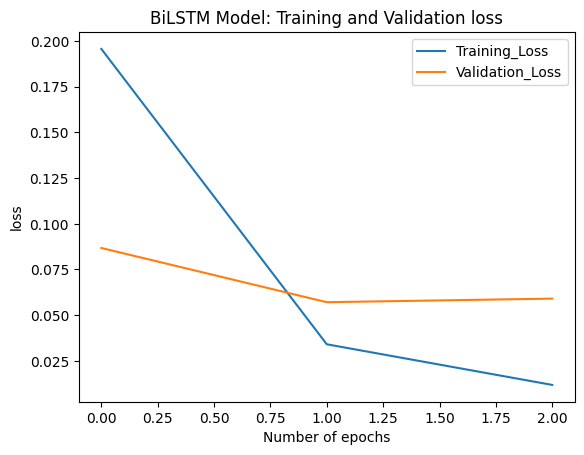

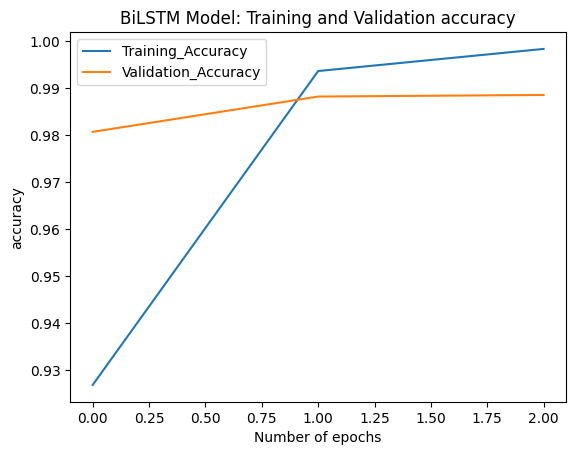

In [ ]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [ ]:
metrics.head()


,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.195724,0.926921,0.086773,0.980748
1,0.034063,0.993688,0.057096,0.988260
2,0.011820,0.998392,0.059053,0.988601


In [ ]:
y_pred = model2.predict(x_test)
y_pred.shape

104/104 [==============================] - 2s 8ms/step


(3309, 250, 1)

In [ ]:
def sigmoid(x):
    if x>=0.5:
        return 1
    else:
        return 0 

In [ ]:
for i in range (len(y_pred)):
    for j in range (len(y_pred[i])):
        y_pred[i][j]= sigmoid(y_pred[i][j])

In [ ]:
pred = []
for i in range (len(y_pred)):
    pred.append(int(y_pred[i].all()))


In [ ]:
np.set_printoptions(threshold=np.inf)


In [ ]:
print(classification_report(y_pred=pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2410
           1       0.99      0.96      0.98       899

    accuracy                           0.99      3309
   macro avg       0.99      0.98      0.98      3309
weighted avg       0.99      0.99      0.99      3309



## BERT

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle

In [ ]:
N_EPOCHS = 3
MODEL_NAME = 'distilbert-base-uncased'

In [ ]:
x = data['text']
y = data['spam']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-TRAIN_SIZE,random_state=2, stratify=y)

In [ ]:
input = x_train.tolist()

In [ ]:
MAX_LEN = 250

tkzr = DistilBertTokenizer.from_pretrained(MODEL_NAME)

inputs = tkzr(input, max_length=MAX_LEN, truncation=True, padding=True)

def construct_tfdataset(encodings, y=None):
      return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    
tfdataset = construct_tfdataset(inputs, y_train)

In [ ]:
BATCH_SIZE = 2

tfdataset = tfdataset.shuffle(len(x_train))
tfdataset = tfdataset.batch(BATCH_SIZE)

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_39', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
model.fit(tfdataset,batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Epoch 1/3
6559/6616 [============================>.] - ETA: 4s - loss: 0.0756 - accuracy: 0.9735

In [ ]:
def construct_test_tfdataset(encodings):
      return tf.data.Dataset.from_tensor_slices(dict(encodings))

to_test = x_test.tolist()
to_test = tkzr(to_test, max_length=MAX_LEN, truncation=True, padding=True)
to_test = construct_test_tfdataset(to_test)

In [ ]:
# benchmarks = model.evaluate(to_test, return_dict=True, batch_size=BATCH_SIZE)
# print(benchmarks)

In [ ]:
preds = model.predict(to_test).logits
preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()
spam_preds = preds[:,1]
spam_preds = np.round(spam_preds)

In [ ]:
print(classification_report(y_pred=spam_preds, y_true=y_test))